
# Apple & Google Twitter Sentiment Analysis

This is a notebook that builds an NLP model to analyze sentiment in tweets about Apple and Google products using the "judge-1377884607_tweet_product_company.csv" dataset.

**Pipeline:**
- Load and inspect dataset  
- Normalize labels into three {positive, negative, neutral}  
- Filter to Apple/Google related targets  
- Train/test split  
- TF-IDF + Logistic Regression model  
- Evaluate and plot results  
- Save model and predictions  


In [22]:
# Incorporating the necessary libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib


In [23]:
#Loading the dataset

DATA_PATH = r"C:\Users\admin\Desktop\Project phase4\judge_1377884607_tweet_product_company.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [24]:
#Inspecting the dataset

df.columns


Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [25]:
#Normalizing labels into three 

TEXT_COL = "tweet_text"
LABEL_COL = "is_there_an_emotion_directed_at_a_brand_or_product"
TARGET_COL = "emotion_in_tweet_is_directed_at"

LABEL_NORMALIZATION = {
    "no emotion toward brand or product": "neutral",
    "i can't tell": "neutral",
    "neutral": "neutral",
    "positive emotion": "positive",
    "positive": "positive",
    "negative emotion": "negative",
    "negative": "negative",
}
ALLOWED_LABELS = {"positive", "negative", "neutral"}


In [26]:
# Filter to Apple/Google related targets

df = df.copy()
df[TEXT_COL] = df[TEXT_COL].astype(str)
df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip().str.lower().map(lambda x: LABEL_NORMALIZATION.get(x, x))

before = len(df)
df = df[df[LABEL_COL].isin(ALLOWED_LABELS)].copy()
after = len(df)
print(f"Loaded {before} rows; kept {after} rows with labels in {ALLOWED_LABELS}.")

apple_google_keywords = {
    "apple","iphone","ipad","ipad or iphone app","other apple product or service",
    "google","android","android app","other google product or service"
}
df[TARGET_COL] = df[TARGET_COL].astype(str).str.strip()
mask_ag = df[TARGET_COL].str.lower().isin(apple_google_keywords)
df = df[mask_ag].copy()
print(f"Filtered to Apple/Google-related targets: kept {len(df)} rows.")

df.head()


Loaded 8721 rows; kept 8721 rows with labels in {'negative', 'neutral', 'positive'}.
Filtered to Apple/Google-related targets: kept 3169 rows.


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive


In [27]:
# Train/test split

X = df[TEXT_COL].values
y = df[LABEL_COL].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
)


In [28]:
# TF-IDF + Logistic Regression model

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9,
        strip_accents="unicode",
        lowercase=True
    )),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear"))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 strip_accents='unicode')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    solver='liblinear'))])

In [29]:

y_pred = pipe.predict(X_val)
acc = accuracy_score(y_val, y_pred)
macro_f1 = f1_score(y_val, y_pred, average="macro")
print(f"Validation Accuracy: {acc:.3f}")
print(f"Validation Macro F1: {macro_f1:.3f}\n")
print(classification_report(y_val, y_pred, digits=3))


Validation Accuracy: 0.836
Validation Macro F1: 0.440

              precision    recall  f1-score   support

    negative      0.638     0.303     0.411        99
     neutral      0.000     0.000     0.000        19
    positive      0.855     0.969     0.908       516

    accuracy                          0.836       634
   macro avg      0.498     0.424     0.440       634
weighted avg      0.795     0.836     0.803       634



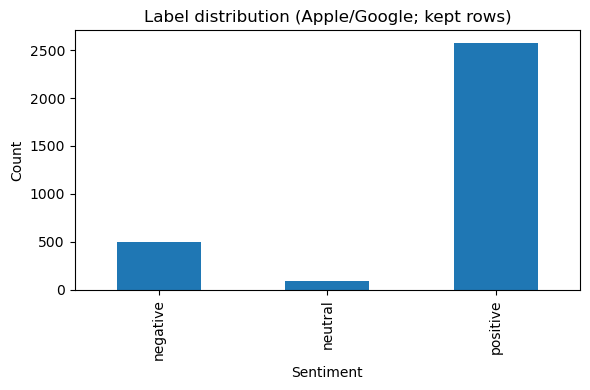

In [30]:
# Evaluate and plot results

label_counts = pd.Series(y).value_counts().sort_index()
plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.title("Label distribution (Apple/Google; kept rows)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [31]:

labels_sorted = sorted(ALLOWED_LABELS)
cm = confusion_matrix(y_val, y_pred, labels=labels_sorted)
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels_sorted], columns=[f"pred_{l}" for l in labels_sorted])
cm_df


,pred_negative,pred_neutral,pred_positive
true_negative,30,0,69
true_neutral,3,0,16
true_positive,14,2,500


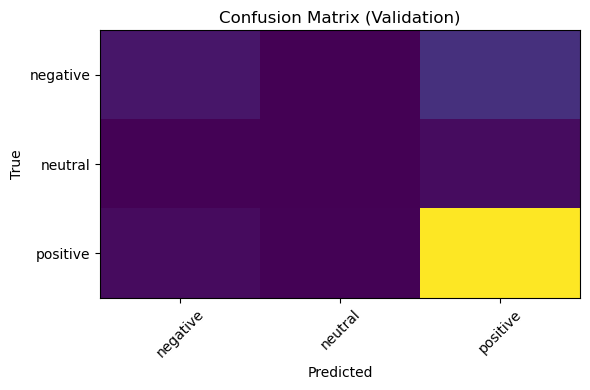

In [32]:

plt.figure(figsize=(6,4))
plt.imshow(cm, aspect='auto')
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=range(len(labels_sorted)), labels=labels_sorted, rotation=45)
plt.yticks(ticks=range(len(labels_sorted)), labels=labels_sorted)
plt.tight_layout()
plt.show()


In [33]:

model_path = "apple_google_twitter_sentiment.joblib"
joblib.dump(pipe, model_path)

proba_supported = hasattr(pipe.named_steps["clf"], "predict_proba")
if proba_supported:
    proba = pipe.predict_proba(df[TEXT_COL].values)
    proba_df = pd.DataFrame(proba, columns=[f"proba_{c}" for c in pipe.named_steps["clf"].classes_])
    preds = pipe.predict(df[TEXT_COL].values)
    out_df = df[[TEXT_COL, LABEL_COL, TARGET_COL]].copy()
    out_df["pred"] = preds
    out_df = pd.concat([out_df.reset_index(drop=True), proba_df.reset_index(drop=True)], axis=1)
else:
    preds = pipe.predict(df[TEXT_COL].values)
    out_df = df[[TEXT_COL, LABEL_COL, TARGET_COL]].copy()
    out_df["pred"] = preds

preds_path = "apple_google_predictions.csv"
out_df.to_csv(preds_path, index=False)

print(f"Model saved to {model_path}")
print(f"Predictions saved to {preds_path}")


Model saved to apple_google_twitter_sentiment.joblib
Predictions saved to apple_google_predictions.csv


In [34]:

# Example usage after saving model
pipe = joblib.load("apple_google_twitter_sentiment.joblib")
texts = ["Love my new iPhone!", "Pixel battery is terrible."]
print(pipe.predict(texts))


['positive' 'negative']
